In [93]:
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd
import numpy as np
import gzip
import json
import re
import os
import sys
import prince
import category_encoders as ce   # version 1.2.8
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from fuzzywuzzy import fuzz
import seaborn as sns

sns.set()


%matplotlib inline

Removing tags who have only one count, not significant enough, and if books have less than one tag remove them from database

In [20]:
# get data needed to facilitate processing
def get_data(inputdata):
    books = []
    with open(inputdata) as json_file:
        for lines in json_file:
            book = {}
            line = json.loads(lines)
            
            names = [elm['name'] for elm in line['popular_shelves'] if int(elm['count']) > 2]
            counts = [elm['count'] for elm in line['popular_shelves'] if int(elm['count']) > 2]
            if len(names) > 1: 
                book['isbn'] = line['isbn']
                book['book_id'] = line['book_id']
                book['popular_shelves'] = names
                book['count_shelves'] = counts
                book['average_rating'] = line['average_rating']
                book['title'] = line['title']
                books.append(book)
    return books

In [21]:
books = get_data('data_category_20-09.json')

In [22]:
len(books)

424819

In [23]:
df = pd.DataFrame(books)
df.head()

,average_rating,book_id,count_shelves,isbn,popular_shelves,title
0,3.93,6066814,"[159, 12, 11, 10, 7, 6, 5, 3, 3, 3, 3]",184737297X,"[to-read, historical-fiction, mystery, histori...","Crowner Royal (Crowner John Mystery, #13)"
1,3.65,2008911,"[44, 7, 3, 3, 3]",0440083087,"[to-read, short-stories, fiction, french, fran...",Silken Eyes
2,3.48,7203847,"[7615, 1526, 1108, 866, 321, 317, 246, 245, 24...",0142427896,"[to-read, horror, stephen-king, fiction, curre...",The Tommyknockers
3,3.75,6158967,"[362, 25, 24, 10, 9, 8, 8, 7, 6, 4, 4, 3]",1400041694,"[to-read, currently-reading, non-fiction, soci...",Crude World: The Violent Twilight of Oil
4,4.04,12182387,"[1057, 101, 59, 58, 55, 36, 35, 26, 25, 25, 19...",,"[to-read, young-adult, ya, paranormal, fantasy...","The Passion (Dark Visions, #3)"


Now let's see how many unique tags this df contains: 60311

In [26]:
alltags = [elm for book in df['popular_shelves'] for elm in book]

In [27]:
len(list(set(alltags)))

60311

Remove the identified useless tags so far, selection of more than 2 counts helps reducing the irrelevant tags

In [28]:
def clean_data_nasty_tags(dfin):

    popular_shelves = dfin['popular_shelves']
    count_shelves = dfin['count_shelves']
    
    popnew = []
    cnew = []

    for elm, elmc in zip(popular_shelves, count_shelves):    
        to_remove = []
        for i in range(len(elm)):
            if (len(elm[i]) == 1) or (bool(re.match('.*book*', elm[i])) == True)\
            or (bool(re.match('.*read*', elm[i])) == True) or (bool(re.match('.*favorite*', elm[i])) == True)\
            or (bool(re.match('.*need*', elm[i])) == True) or (bool(re.match('.*own*', elm[i])) == True)\
            or (bool(re.match('.*shelve*', elm[i])) == True) or (bool(re.match('.*like*', elm[i])) == True)\
            or (bool(re.match('.*shelf*', elm[i])) == True) or (bool(re.match('.*buy*', elm[i])) == True)\
            or (bool(re.match('tbr', elm[i])) == True) or (bool(re.match('.*finish*', elm[i])) == True)\
            or (bool(re.match('.*kindle*', elm[i])) == True) or (bool(re.match('.*list*', elm[i])) == True)\
            or (bool(re.match('.*year*', elm[i])) == True) or (bool(re.match('.*audio*', elm[i])) == True)\
            or (bool(re.match('.*library*', elm[i])) == True) or (bool(re.search(r'\d+', elm[i])) == True)\
            or (bool(re.match('[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', elm[i])) == True):
                #print(i, elm[i])
                to_remove.append(i) 
        #print(to_remove)
        
        popnew.append([elm[e] for e in range(len(elm)) if e not in to_remove])
        cnew.append([elmc[e] for e in range(len(elmc)) if e not in to_remove])
 
    return popnew, cnew

In [29]:
pop, count = clean_data_nasty_tags(df)

Update dataframe with removed tags

In [31]:
new_column_p = pd.Series(pop, name='popular_shelves', index=range(len(pop)))
new_column_c = pd.Series(count, name='count_shelves', index=range(len(count)))

df.update(new_column_p)
df.update(new_column_c)

Check the number of unique tags again

In [32]:
alltags = [elm for book in df['popular_shelves'] for elm in book]
len(set(alltags))

48653

In [34]:
#print(set(alltags))

In [36]:
new_column_p[:5]

0    [historical-fiction, mystery, historical-myste...
1           [short-stories, fiction, french, français]
2    [horror, stephen-king, fiction, sci-fi, scienc...
3    [non-fiction, society, politics, history, econ...
4    [young-adult, ya, paranormal, fantasy, romance...
Name: popular_shelves, dtype: object

In [37]:
new_column_c[:5]

0                          [12, 11, 10, 7, 6, 5, 3, 3]
1                                         [7, 3, 3, 3]
2    [1526, 1108, 866, 317, 240, 231, 170, 160, 108...
3                        [24, 10, 9, 8, 8, 7, 6, 4, 3]
4    [101, 59, 58, 55, 35, 26, 25, 19, 16, 16, 14, ...
Name: count_shelves, dtype: object

In [60]:
p = [tag for elm in new_column_p for tag in elm]
c = [int(tag) for elm in new_column_c for tag in elm]
len(p), len(c)

(8270328, 8270328)

Extract each tag and the associated count to calculate some statistics and group them.
Total number of tags (non unique) 8,270,328

In [61]:
ps = pd.Series(p, name='popular_shelves', index=range(len(p)))
cs = pd.Series(c, name='count_shelves', index=range(len(c)))

tags = pd.concat([ps, cs], axis=1)

In [62]:
tags.head()

,popular_shelves,count_shelves
0,historical-fiction,12
1,mystery,11
2,historical-mystery,10
3,medieval,7
4,historical,6


In [65]:
new = tags.groupby('popular_shelves')['count_shelves'].sum().reset_index(name ='Total Counts')

In [66]:
new.head()

,popular_shelves,Total Counts
0,-calif--,324
1,-civilization-,16
2,-computers-,16
3,-conn--,32
4,-d-c--,174


In [67]:
new.sort_values(by=['Total Counts'], ascending=False, inplace=True)

In [69]:
new.head(15)

,popular_shelves,Total Counts
8881,classics,48239535
15554,fiction,47770426
15069,fantasy,21880760
37378,romance,13745490
30948,mystery,11678148
19821,historical-fiction,10584823
48389,young-adult,10162180
8825,classic,9563016
38739,science-fiction,8435301
32104,non-fiction,6557855


Merge some tags, such as classic and classics

In [85]:
ps = pd.Series(p, name='popular_shelves', index=range(len(p))).str.replace('classics', 'classic', regex=True)
ps1 = ps.str.replace('scifi', 'science-fiction', regex=True)
ps2 = ps1.str.replace('sci-fi', 'science-fiction', regex=True)
ps3 = ps2.str.replace('ya', 'young-adult', regex=True)

tags = pd.concat([ps3, cs], axis=1)
new = tags.groupby('popular_shelves')['count_shelves'].sum().reset_index(name ='Total Counts')
new.sort_values(by=['Total Counts'], ascending=False, inplace=True)

In [86]:
 new[new['popular_shelves'] == 'classic']

,popular_shelves,Total Counts
8819,classic,57802551


In [87]:
len(tags)

8270328

In [88]:
new.sum(axis = 0, skipna = True) 

popular_shelves    classicfictionfantasyscience-fictionyoung-adul...
Total Counts                                               444897848
dtype: object

Get ratio of each shelve

In [89]:
new['Total Counts'] = new['Total Counts']/444897848

In [90]:
new.head(10)

,popular_shelves,Total Counts
8819,classic,0.129923
15529,fiction,0.107374
15051,fantasy,0.049182
38640,science-fiction,0.036436
48157,young-adult,0.034060
37324,romance,0.030896
30897,mystery,0.026249
19782,historical-fiction,0.023792
32052,non-fiction,0.014740
26424,literature,0.013537


In [91]:
len(new)

48534

In [92]:
new.to_csv('tags_unique_count.csv', index=False)

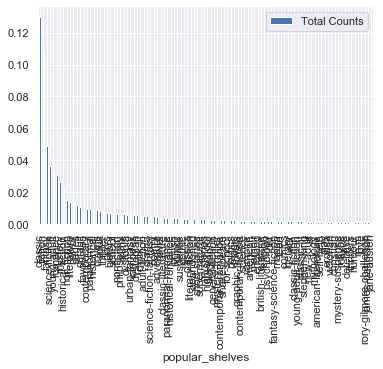

In [103]:
#new.iloc[:100, :].hist(cumulative=True)
new.iloc[:100, :].plot.bar(x = 'popular_shelves', y = 'Total Counts', grid = True)

In [105]:
new['cdf'] = new['Total Counts'].cumsum()

In [106]:
new.head()

,popular_shelves,Total Counts,cdf
8819,classic,0.129923,0.129923
15529,fiction,0.107374,0.237297
15051,fantasy,0.049182,0.286479
38640,science-fiction,0.036436,0.322915
48157,young-adult,0.034060,0.356975


In [111]:
#new.iloc[:400, :].plot.bar(x = 'popular_shelves', y = 'cdf', grid = True)

In [109]:
new.to_csv('tags_unique_count.csv', index=False)

In [113]:
len(new[new['cdf'] <= 0.9])

332

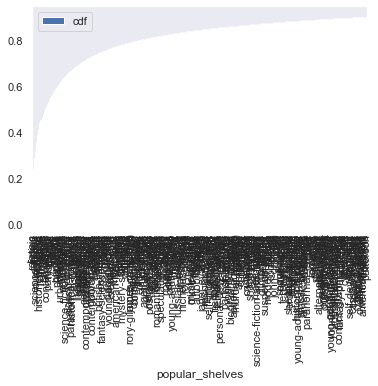

In [115]:
new.iloc[:333, :].plot.bar(x = 'popular_shelves', y = 'cdf', grid = False)

In [120]:
selected_tags = new.iloc[:332, :]
selected_tags.to_csv('selected_tags.csv', index=False)

In [121]:
list_tags = selected_tags['popular_shelves'].to_list()

In [122]:
len(list_tags)

332

At this point 332 shelves are selected, now only keep those in book dataframe.

In [124]:
def get_selected_tags(pops, cs, tags):
    genreExceptions = [
    'to-read', 'currently-reading', 'owned', 'default', 'favorites', 'books-i-own',
    'ebook', 'kindle', 'library', 'audiobook', 'owned-books', 'audiobooks', 'my-books',
    'ebooks', 'to-buy', 'english', 'calibre', 'books', 'british', 'audio', 'my-library',
    'favourites', 're-read', 'general', 'e-books', 'ibooks', 'may-2017-dr-reads', 'favorite-authors',
    'series-i-like', 'ebook-unread', 'wishlist', 'did-not-finish', 'a-wishlist', 'wish-list',
    '-library-no-owned', '0-0-asap', '0-gu', '0-medieval-fiction', '0-owned', 'owned', '0-too-lazy-to-tag',
    'owned-tbr', 'wishlist', 'a-wishlist', 'did-not-finish'
    ]

    popnew = []
    cnew = []

    for elm, elmc in zip(pops, cs):    
        to_keep = []
        for i in range(len(elm)):
            if elm[i] in tags:
                to_keep.append(i) 
        popnew.append([elm[e] for e in range(len(elm)) if e in to_keep])
        cnew.append([elmc[e] for e in range(len(elmc)) if e in to_keep])
    
    return popnew, cnew



In [126]:
pop, count = get_selected_tags(df['popular_shelves'], df['count_shelves'], list_tags)

new_column_p = pd.Series(pop, name='popular_shelves', index=range(len(pop)))
new_column_c = pd.Series(count, name='count_shelves', index=range(len(count)))

In [127]:
df.update(new_column_p)
df.update(new_column_c)

In [128]:
df.head()

,average_rating,book_id,count_shelves,isbn,popular_shelves,title
0,3.93,6066814,"[12, 11, 10, 7, 6, 5, 3, 3]",184737297X,"[historical-fiction, mystery, historical-myste...","Crowner Royal (Crowner John Mystery, #13)"
1,3.65,2008911,"[7, 3, 3]",0440083087,"[short-stories, fiction, french]",Silken Eyes
2,3.48,7203847,"[1526, 1108, 866, 240, 231, 170, 160, 108, 99,...",0142427896,"[horror, stephen-king, fiction, science-fictio...",The Tommyknockers
3,3.75,6158967,"[24, 9, 8, 8, 7]",1400041694,"[non-fiction, politics, history, economics, no...",Crude World: The Violent Twilight of Oil
4,4.04,12182387,"[101, 58, 55, 35, 26, 25, 19, 16, 14, 11, 9, 6...",,"[young-adult, paranormal, fantasy, romance, ur...","The Passion (Dark Visions, #3)"


In [129]:
df.to_csv('books_tags332.csv', index=False)